## Multiclass classification  $\rightarrow$  Newswire classifcation
___

We will build a network to classify Reuters neswires into **46** mutually exclusive topics. Because of more class than, this  problem is an instance of multiclass classification and beacuse each data point should be classified into only one category, the problem is more specifically an instance of single-label, multiclass classisifcation.If each data point could be belong to multiple categoties you,d be facing `multilabel, multiclass classifcation` problem.

#### Reuters dataset
___

This is a set of short newswires and their topics,published by Reuters in 1986.It's a simple, widely used toy dataset for text classifcation. There are 46 different topics; some topics are more represented then others, but each topic has at leat 10 examples in the training set.

##### Loading the Dataset
___

In [310]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import reuters
import warnings
warnings.filterwarnings("ignore")
from collections import Counter

In [2]:
(train_data,train_labels),(test_data,test_labels) = reuters.load_data(num_words=10000)  ## restricting to 10000 word limit

In [3]:
len(train_data)

8982

In [4]:
len(test_data)

2246

In [5]:
print(train_data[0]) ## list of encoded words of a sentence

[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]


### Data distribution visualization

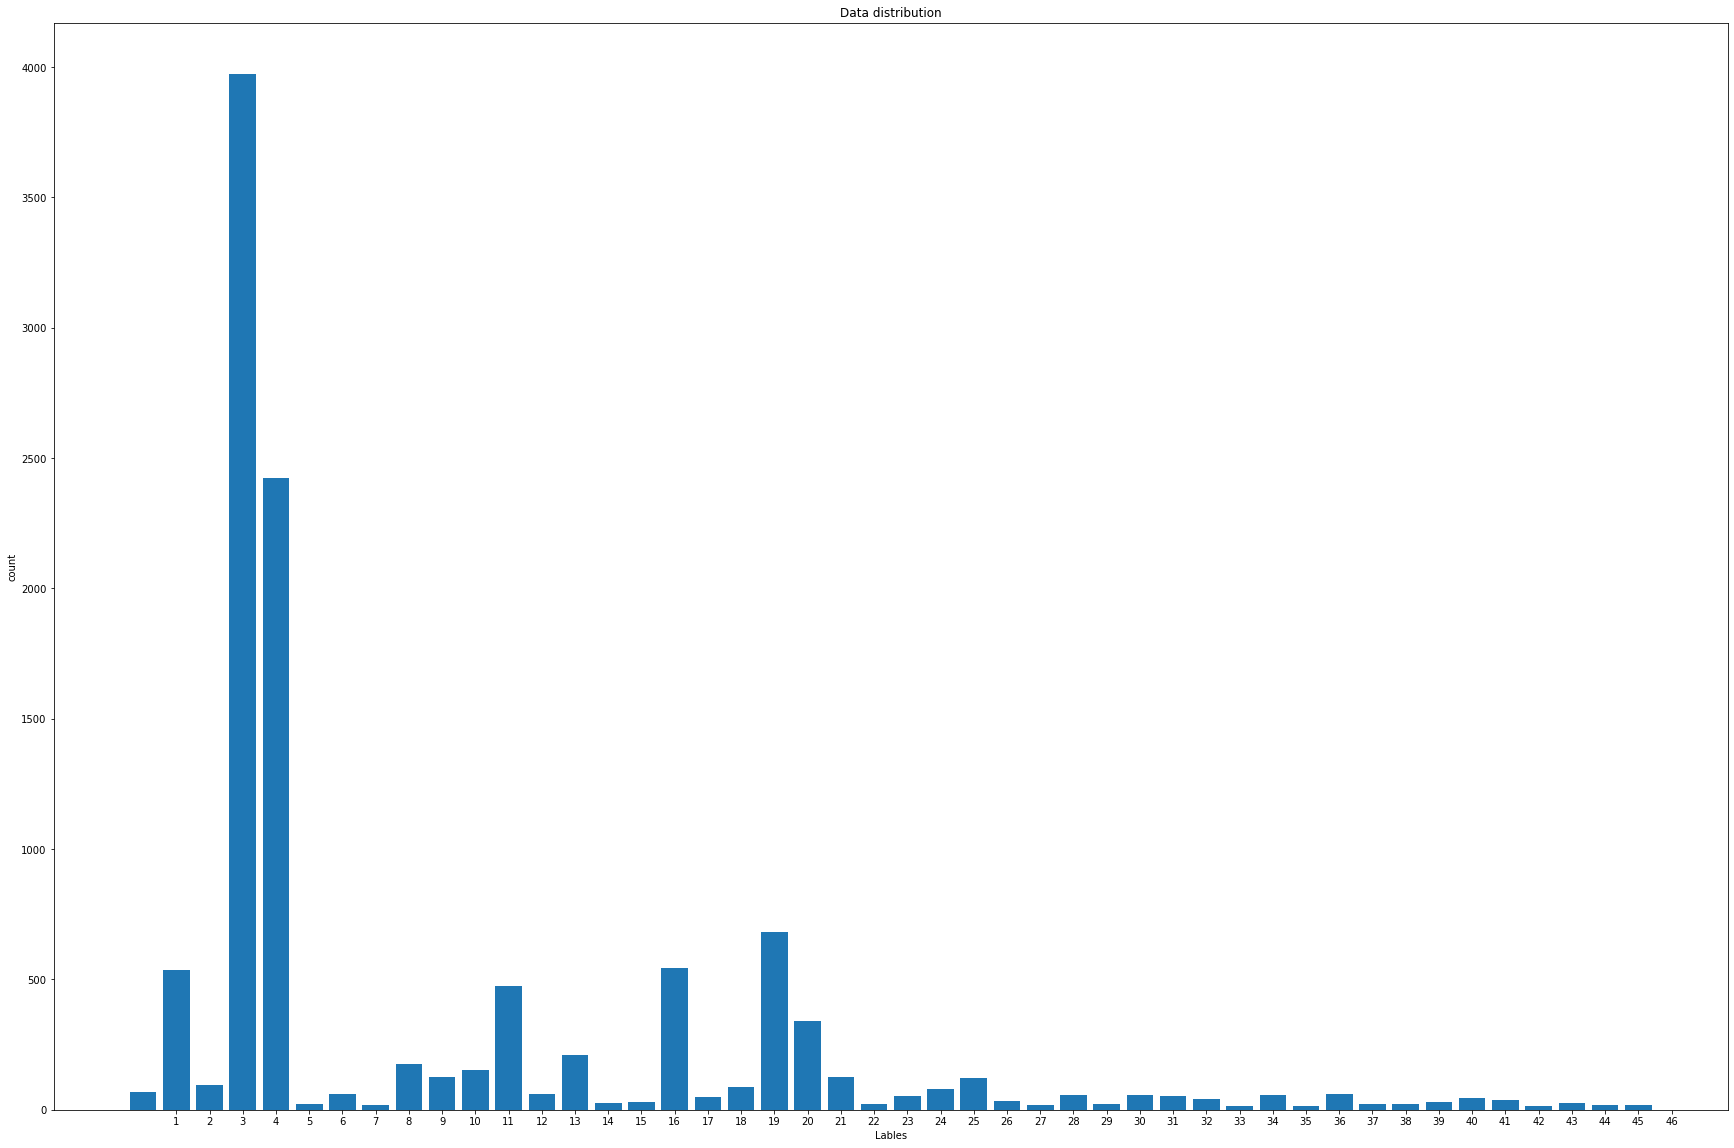

In [329]:
labels = np.append(train_labels,test_labels)
count = Counter(labels)
keys = list(count.keys())
values = list(count.values())

plt.figure(figsize=(30,20))
plt.bar(x=keys,height=values,)
plt.xlabel("Lables")
plt.ylabel("count")
plt.xticks(np.arange(1,47))
plt.title("Data distribution")

plt.show()

##### Decoding newsire to back to text
___

In [6]:
word_index = reuters.get_word_index()
reverse_word_index = dict(([value,key]for key,value in word_index.items()))
decoded_word = " ".join([reverse_word_index.get(i-3,"?") for i in train_data[88]])

In [7]:
decoded_word

'? lt shell canada ltd 72 pct owned by royal dutch shell group anticipates an improved level of earnings in 1987 assuming a continuation of prices and margins that existed at the end of 1986 and early 1987 the company said in the annual report shell previously reported 1986 operating profit fell to 130 mln dlrs excluding a 24 mln dlr unusual gain from 146 mln dlrs in the prior year the company also said 1987 capital and exploration spending of 420 mln dlrs will be 160 mln dlrs lower than last year due to the uncertain short term outlook 3'

##### Preparing the data
___

**Encoding the data**
___

In [8]:
import numpy as np

def vectorize_sequences(sequences,dimension=10000):
    results = np.zeros((len(sequences),dimension))
    for i,sequence in enumerate(sequences):
        results[i,sequence] = 1
    return results

In [261]:
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

To vectorize the labels, there are two possiblities; you can cast the lable list as ain integer tensor, or you can use one-hot encoding. One-hot encoding is a widely used format for categorical data, also called `categorical encoding`.In this case one-hot encoding the lables consists of embedding each label as an all-zero vector with a 1 in the place of the label index

In [262]:
def to_one_hot(labels,dimension=46):
    results = np.zeros((len(labels),dimension))
    for i,label in enumerate(labels):
        results[i,label] = 1
    return results

In [263]:
to_one_hot(train_labels)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

**There is a builtin method in keras to convert labels into one-hot encoding method  `to_categorical`.**

In [264]:
from tensorflow.keras.utils import to_categorical

In [265]:
one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

In [266]:
one_hot_train_labels[0]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

### Building the network
___

The classification problem in this case is similar to the binary one,which we used to solve previous case but here in this case the dimensionality of the output space is much larger.  

In a stack on `Dense` layers like the ayou've been using, each layer can only access information present in the output of the previous layer.If one layer drops some information relevant to the classifcation problem, this information can never be recovered by later layers: Each layer can potentially become an information bottleneck.In previous work we have used 16-dimensional space, which is too limited to learn to seprate 46 different classes: **Such small layers may act as information bottlenecks, permananetly dropping relevant information**.Hence in this case we are using 64 unit dense layer.  

#### Model Defination

In [18]:
from tensorflow.keras import models,layers
from warnings import filterwarnings
filterwarnings("ignore")

In [74]:
model = models.Sequential()
model.add(layers.Dense(units=64,activation="relu",input_shape = (10000,)))
model.add(layers.Dense(units=64,activation="relu"))
model.add(layers.Dense(units=46,activation="softmax"))

There are two other things you should note about this architecture:  

>1. The network is ended with a `Dense layer` of size 46. This means for each input smaple, the network will output a 46 dimenisonal vector.Each entry in this vector (Each dimension) will encode a different output class.  

>2. The last layer uses a `softmax` function.It means the network will output a `proabablity distribution`  over the 46 different output classes- for every input sample, the network will profuce a 46-dimesnional output vector, where `output[i]` is the probabiltiy that the sample belongs to class i.The  46 score will some to one.  

The best loss function to use this case is `categorical_crossentropy`.It measures the distance between two proabablity sitributions:here, between the probability distribution output by the network and the true distribution of the labels.By minimizing the distance between two distributions, you train the network to output something as close as possible to the true labels.  

### Compiling the model

In [76]:
model.compile(optimizer="rmsprop",loss="categorical_crossentropy",metrics=["accuracy"])

In [118]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 64)                640064    
_________________________________________________________________
dense_19 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_20 (Dense)             (None, 46)                2990      
Total params: 647,214
Trainable params: 647,214
Non-trainable params: 0
_________________________________________________________________


### Validating your approach 

Seprate 1000 samples apart in training data to use as a validation set.

In [267]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

### Training the model

In [78]:
history = model.fit(x= partial_x_train,y=partial_y_train,batch_size=512,epochs=20,validation_data= (x_val,y_val))

Epoch 1/20
16/16 [==============================] - 1s 50ms/step - loss: 3.0951 - accuracy: 0.4168 - val_loss: 1.7733 - val_accuracy: 0.6260
Epoch 2/20
16/16 [==============================] - 1s 33ms/step - loss: 1.5457 - accuracy: 0.6830 - val_loss: 1.3348 - val_accuracy: 0.7130
Epoch 3/20
16/16 [==============================] - 1s 33ms/step - loss: 1.1315 - accuracy: 0.7615 - val_loss: 1.1630 - val_accuracy: 0.7610
Epoch 4/20
16/16 [==============================] - 1s 33ms/step - loss: 0.8860 - accuracy: 0.8108 - val_loss: 1.0574 - val_accuracy: 0.7800
Epoch 5/20
16/16 [==============================] - 1s 34ms/step - loss: 0.6961 - accuracy: 0.8551 - val_loss: 0.9989 - val_accuracy: 0.7890
Epoch 6/20
16/16 [==============================] - 1s 33ms/step - loss: 0.5668 - accuracy: 0.8870 - val_loss: 0.9844 - val_accuracy: 0.7810
Epoch 7/20
16/16 [==============================] - 1s 33ms/step - loss: 0.4363 - accuracy: 0.9131 - val_loss: 0.9161 - val_accuracy: 0.8160
Epoch 8/20
16

### Plotting learning curve

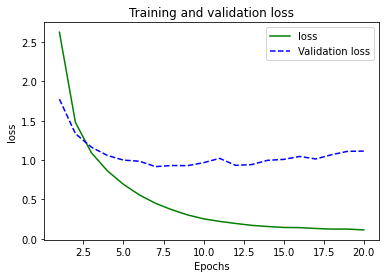

In [79]:
import matplotlib.pyplot as plt

loss = history.history["loss"]
val_loss = history.history["val_loss"]

plt.clf()
plt.plot([i for i in range(1,21)],loss,color="green",label="loss")
plt.plot([i for i in range(1,21)],val_loss,color="blue",label="Validation loss",linestyle="dashed",)
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("loss")

plt.legend()
plt.show()


### Plotting accuracy curve

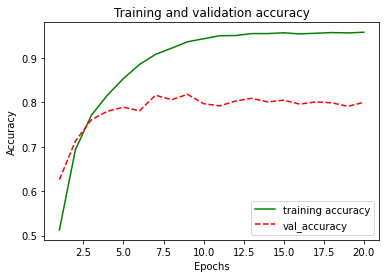

In [81]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]

plt.clf()

plt.plot([i for i in range(1,21)],accuracy,color="green",label="training accuracy")
plt.plot([i for i in range(1,21)],val_accuracy,color="red",linestyle="dashed",label="val_accuracy")
plt.title("Training and validation accuracy")

plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.legend()

plt.show()

**The netowrk begins to overfit after 9 epochs**

### Retraining a model from scratch

In [111]:
model = models.Sequential()
model.add(layers.Dense(units=64,activation="relu",input_shape=(10000,)))
model.add(layers.Dense(units=64,activation="relu"))
model.add(layers.Dense(units=46,activation="softmax"))

In [112]:
model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
             metrics=["accuracy"])

In [113]:
history = model.fit(x=partial_x_train,
          y=partial_y_train,
         epochs=9,
         batch_size=512,
         validation_data = (x_val,y_val))

Epoch 1/9
16/16 [==============================] - 1s 52ms/step - loss: 3.1837 - accuracy: 0.3779 - val_loss: 1.7506 - val_accuracy: 0.6590
Epoch 2/9
16/16 [==============================] - 1s 33ms/step - loss: 1.5367 - accuracy: 0.6940 - val_loss: 1.2767 - val_accuracy: 0.7270
Epoch 3/9
16/16 [==============================] - 1s 34ms/step - loss: 1.0695 - accuracy: 0.7752 - val_loss: 1.1000 - val_accuracy: 0.7750
Epoch 4/9
16/16 [==============================] - 1s 33ms/step - loss: 0.8371 - accuracy: 0.8262 - val_loss: 0.9862 - val_accuracy: 0.7970
Epoch 5/9
16/16 [==============================] - 1s 34ms/step - loss: 0.6791 - accuracy: 0.8591 - val_loss: 0.9435 - val_accuracy: 0.8070
Epoch 6/9
16/16 [==============================] - 1s 34ms/step - loss: 0.5398 - accuracy: 0.8927 - val_loss: 0.8960 - val_accuracy: 0.8080
Epoch 7/9
16/16 [==============================] - 1s 33ms/step - loss: 0.4231 - accuracy: 0.9102 - val_loss: 0.8545 - val_accuracy: 0.8210
Epoch 8/9
16/16 [===

### Plotting learning curve
___

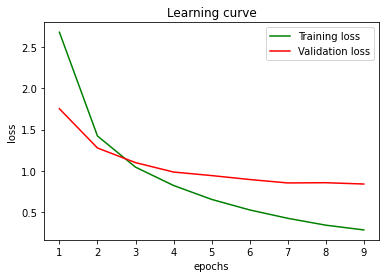

In [114]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]

plt.clf()
plt.plot([i for i in range(1,10)],loss,color="green",label="Training loss")
plt.plot([i for i in range(1,10)],val_loss,color="red",label="Validation loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Learning curve")
plt.legend()
plt.show()

In [115]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

## Plotting accuracy curve

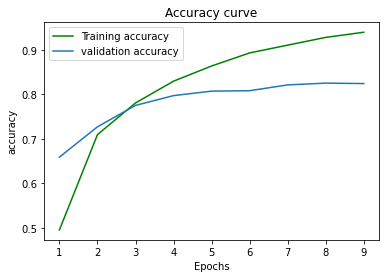

In [117]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]

plt.clf()
plt.plot([i for i in range(1,10)],accuracy,color="green",label="Training accuracy")
plt.plot([i for i in range(1,10)],val_accuracy,label="validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.legend()
plt.title("Accuracy curve")
plt.show()

In [124]:
results = model.evaluate(x=x_test,y=one_hot_test_labels)

71/71 [==============================] - 1s 4ms/step - loss: 0.9742 - accuracy: 0.7894


In [126]:
results

[0.9742046594619751, 0.7894033789634705]

This approach gives an accuracy of ~80% . With a balanced binary classification proble,, the accuracy reached by a purely random classifier would be 50%.But in this case it is close to 19%

In [148]:
import copy
test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)

hits_array = np.array(test_labels_copy) == np.array(test_labels)

hits_array

float(np.sum(hits_array)/len(test_labels))

0.18477292965271594

### Generating predictions on new data
___

You can verify the `predict` method of the model instance return a **probability ditribution over all 46 pairs topics**, let's generate topic predictions doe all oft he test data

In [149]:
predictions = model.predict(x_test)

The shape of result on a single data (sentence) is a array of **probablity distribution** among 46 use case.

In [153]:
predictions.shape

(2246, 46)

The coefficient in this vector sume is 1

In [215]:
np.sum(predictions[0])

1.0000001

In [219]:
np.argmax(predictions[0])

3

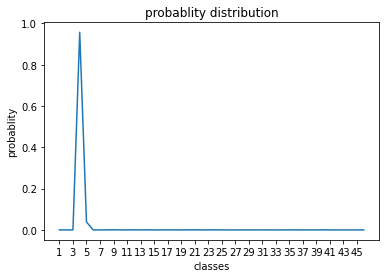

In [220]:
plt.plot([i for i in range(1,47)],predictions[0])
plt.xlabel("classes")
plt.ylabel("probablity")
plt.xticks(np.arange(1,47,step=2),)
plt.title("probablity distribution")
plt.show()

### A different way to handle the labels and the loss
___

Another way to encode the labels would be to cast them as an integer tensor.

In [227]:
y_train = np.array(train_labels)
y_test = np.array(test_labels)

The only thing this approcah would change in the choice of the loss function.The loss function used `categorical_cross_entropy` expects the label to follow a categorical encoding. With integer labels, You shoulf use `sparse_categorical_crossentropy:` **Doubt**  

Use this crossentropy metric when there are **two or more label classes**. We expect labels to be provided as **integers**. If you want to provide labels using one-hot representation, please use CategoricalCrossentropy metric. There should be **# classes floating point values per feature for y_pred** and a single floating point value per feature for y_true.

In [228]:
model.compile(optimizer="rmsprop",loss="sparse_categorical_crossentropy",metrics=["acc"])

In [247]:
from tensorflow.keras.metrics import sparse_categorical_crossentropy

y_true = [1,2]
y_pred = [[0.3,0.6,0.1],
         [0.4,0.3,0.3]]
loss = sparse_categorical_crossentropy(y_true,y_pred,)

In [248]:
loss.numpy()

array([0.5108256, 1.2039728], dtype=float32)

### The importance of having sufficently large inermediate layers
___

Let's introduce an information bottleneck by having intermediate layers that ae significantly less than 46-dimensional, like 4 dimensional.

### A model with information bottleneck

In [271]:
model = models.Sequential()
model.add(layers.Dense(units=64,activation="relu",input_shape=(10000,)))
model.add(layers.Dense(units=4,activation="relu"))
model.add(layers.Dense(units=46,activation="softmax"))

In [272]:
model.compile(optimizer="rmsprop",loss="categorical_crossentropy",metrics=["accuracy"])

In [273]:
history = model.fit(x=partial_x_train,y=partial_y_train,epochs=20,batch_size=128,validation_data=(x_val,y_val))

Epoch 1/20
63/63 [==============================] - 6s 35ms/step - loss: 3.5092 - accuracy: 0.1880 - val_loss: 2.6642 - val_accuracy: 0.4840
Epoch 2/20
63/63 [==============================] - 1s 19ms/step - loss: 2.3979 - accuracy: 0.5141 - val_loss: 1.8465 - val_accuracy: 0.5650
Epoch 3/20
63/63 [==============================] - 1s 19ms/step - loss: 1.7452 - accuracy: 0.5628 - val_loss: 1.6276 - val_accuracy: 0.5990
Epoch 4/20
63/63 [==============================] - 1s 19ms/step - loss: 1.4805 - accuracy: 0.6230 - val_loss: 1.5505 - val_accuracy: 0.6290
Epoch 5/20
63/63 [==============================] - 1s 19ms/step - loss: 1.3288 - accuracy: 0.6815 - val_loss: 1.5292 - val_accuracy: 0.6430
Epoch 6/20
63/63 [==============================] - 1s 20ms/step - loss: 1.2182 - accuracy: 0.6976 - val_loss: 1.4300 - val_accuracy: 0.6520
Epoch 7/20
63/63 [==============================] - 1s 19ms/step - loss: 1.1211 - accuracy: 0.7052 - val_loss: 1.4252 - val_accuracy: 0.6510
Epoch 8/20
63

### on test data

In [276]:
model.evaluate(x_test,one_hot_test_labels)

71/71 [==============================] - 1s 9ms/step - loss: 2.2283 - accuracy: 0.6500


[2.2283194065093994, 0.6500445008277893]

The network now peaks at **~71% validation accuracy**, an **8% absolute drop**.This drop is mostly due to the facts that we are trying to compress lots of information(enough information to recover the sepration hyperplanes of 46 classes) into an intemrediate space that is too low-dimensional.The network is able to cram most of the necessary information into these 4- dimesnonal represenatation but not all of it.

### Let's viusalize the weight that is learned
___

In [297]:
from tensorflow.keras import backend as k
weights = []
for w in model.trainable_weights:
    weights.append(k.eval(w))

In [298]:
len(weights)

6

In [299]:
[weight.shape for weight in weights]

[(10000, 64), (64,), (64, 4), (4,), (4, 46), (46,)]

In [300]:
import pandas as pd
#pd.DataFrame(weights[5])

## Wrapping up
___

1. If you're trying to classify data points among N classes, your network should  end with a `Dense` layer of size N.  

2. In a single-label, multiclass classification problem, your network should end with a `softmax` activations so that it will output a probability distributions over the N output classes.  

3. Categorical crossentropy is almost always the loss function you should use for such problems.It minimizes the distances between the probablity distributions output by the network and the true labels in multiclass classifications.  

4. There are two ways to handle labels in multiclass classifcations:  



    1. Encoding the label via categorical encoding and using categorical_crossentropy as a loss function.  
    
    
    2. Encoding the label as integers and using the sparse_categorical_crossenyropy as loss functions.  

___

>**Note:** 
If you need to classify data into a large number of categories, you should avoid creating information bottlenecks in your network due to intermediate layers that are too small.
___